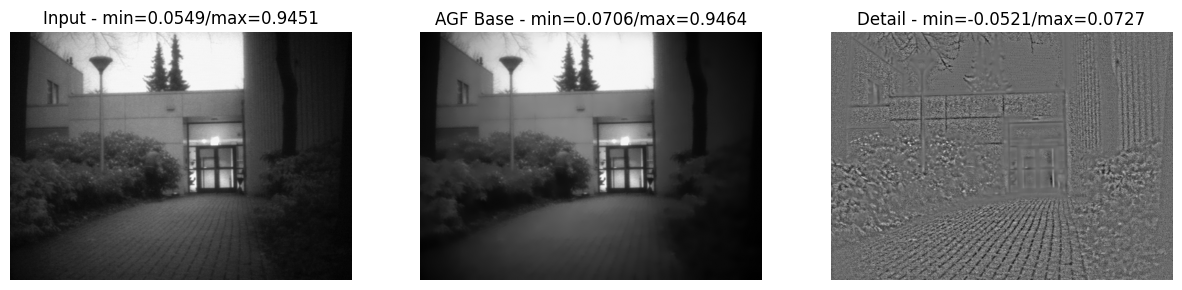

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def guided_filter(I, p, r=2, eps=1e-3):
    """
    Guided Filter
    I: guidance image, float32, [0,1]
    p: filtering input, float32, [0,1]
    r: radius
    eps: regularization
    """
    I = I.astype(np.float32)
    p = p.astype(np.float32)

    ones = np.ones_like(I)

    mean_I = cv2.boxFilter(I, -1, (2*r+1, 2*r+1))
    mean_p = cv2.boxFilter(p, -1, (2*r+1, 2*r+1))
    mean_Ip = cv2.boxFilter(I*p, -1, (2*r+1, 2*r+1))

    cov_Ip = mean_Ip - mean_I * mean_p

    mean_II = cv2.boxFilter(I*I, -1, (2*r+1, 2*r+1))
    var_I = mean_II - mean_I * mean_I

    a = cov_Ip / (var_I + eps)
    b = mean_p - a * mean_I

    mean_a = cv2.boxFilter(a, -1, (2*r+1, 2*r+1))
    mean_b = cv2.boxFilter(b, -1, (2*r+1, 2*r+1))

    q = mean_a * I + mean_b
    return np.clip(q, 0, 1)

def alternating_guided_filter(
    I,
    sigma=3.0,
    r=2,
    eps=1e-3,
    iterations=4
):
    """
    Alternating Guided Filter (AGF)
    I: input image, float32, [0,1]
    """
    I = I.astype(np.float32)
    S = cv2.GaussianBlur(I, (0, 0), sigmaX=sigma, sigmaY=sigma)

    for _ in range(iterations):
        # Step A: recover edges (RGF-like)
        R = guided_filter(I, S, r=r, eps=eps)
        # Step B: restore geometry (SiR-like)
        S = guided_filter(R, I, r=r, eps=eps)

    return np.clip(S, 0, 1)

img = cv2.imread('C:\\LTHH\\data\\TNO\\vi\\17.png', cv2.IMREAD_GRAYSCALE)
img = img.astype(np.float64) / 255.0

# Apply AGF
base = alternating_guided_filter(
    img,
    sigma=3,
    r=5,
    eps=1e-4,
    iterations=2
)

detail = img - base

plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.title(f"Input - min={img.min():.4f}/max={img.max():.4f}"); plt.imshow(img, cmap="gray"); plt.axis("off")
plt.subplot(1,3,2); plt.title(f"AGF Base - min={base.min():.4f}/max={base.max():.4f}"); plt.imshow(base, cmap="gray"); plt.axis("off")
plt.subplot(1,3,3); plt.title(f"Detail - min={detail.min():.4f}/max={detail.max():.4f}"); plt.imshow(detail, cmap="gray"); plt.axis("off")
plt.show()

In [22]:
!pip install opencv-contrib-python


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


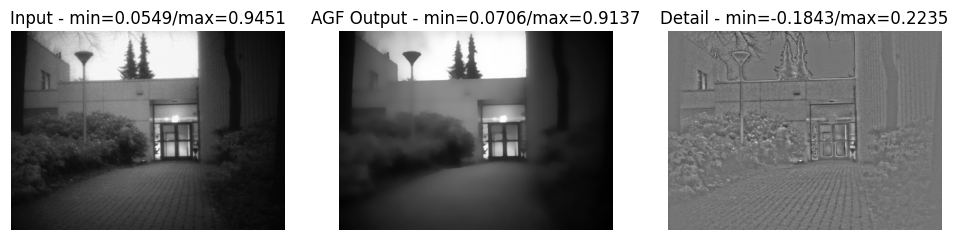

In [26]:
import numpy as np
import cv2

def joint_bilateral_filter(p, I, sigma_spatial, sigma_range):
    """
    Joint Bilateral Filter
    p: input image (float32, [0,1])
    I: guidance image (float32, [0,1])
    """
    radius = int(3 * sigma_spatial)
    kernel_size = 2 * radius + 1

    # Spatial Gaussian
    ax = np.arange(-radius, radius + 1)
    xx, yy = np.meshgrid(ax, ax)
    spatial_kernel = np.exp(-(xx**2 + yy**2) / (2 * sigma_spatial**2))

    H, W = p.shape
    padded_p = np.pad(p, radius, mode="reflect")
    padded_I = np.pad(I, radius, mode="reflect")

    output = np.zeros_like(p, dtype=np.float32)

    for i in range(H):
        for j in range(W):
            patch_p = padded_p[i:i+kernel_size, j:j+kernel_size]
            patch_I = padded_I[i:i+kernel_size, j:j+kernel_size]

            range_kernel = np.exp(
                -((patch_I - padded_I[i+radius, j+radius])**2)
                / (2 * sigma_range**2)
            )

            weights = spatial_kernel * range_kernel
            weights /= np.sum(weights) + 1e-8

            output[i, j] = np.sum(weights * patch_p)

    return np.clip(output, 0, 1)

from numpy.lib.stride_tricks import sliding_window_view

def joint_bilateral_filter_sliding(
    p,
    I,
    sigma_spatial,
    sigma_range
):
    radius = int(3 * sigma_spatial)
    k = 2 * radius + 1

    # Spatial Gaussian
    ax = np.arange(-radius, radius + 1)
    xx, yy = np.meshgrid(ax, ax)
    spatial = np.exp(-(xx**2 + yy**2) / (2 * sigma_spatial**2))

    p_pad = np.pad(p, radius, mode="reflect")
    I_pad = np.pad(I, radius, mode="reflect")

    p_win = sliding_window_view(p_pad, (k, k))
    I_win = sliding_window_view(I_pad, (k, k))

    I_center = I[:, :, None, None]

    range_kernel = np.exp(
        -((I_win - I_center) ** 2) / (2 * sigma_range ** 2)
    )

    weights = spatial * range_kernel
    norm = np.sum(weights, axis=(2, 3)) + 1e-8

    out = np.sum(weights * p_win, axis=(2, 3)) / norm
    return np.clip(out, 0, 1)


def alternating_guided_filter(
    I,
    sigma_spatial=5.0,
    sigma_range=0.05,
    iterations=4,
    median_ksize=3
):
    """
    Alternating Guided Filter (AGF) – paper-original version
    I: input image, float32, [0,1]
    """
    I = I.astype(np.float32)

    # Step 1: Initialize G0 as constant image
    G = np.full_like(I, np.mean(I), dtype=np.float32)

    for _ in range(iterations):
        # Step 3: JBF (input=I, guidance=G)
        G = joint_bilateral_filter_sliding(
            p=I,
            I=G,
            sigma_spatial=sigma_spatial,
            sigma_range=sigma_range
        )

        # Step 4: JBF (input=G, guidance=I)
        G = joint_bilateral_filter_sliding(
            p=G,
            I=I,
            sigma_spatial=sigma_spatial,
            sigma_range=sigma_range
        )

        # Step 5: Median filter
        G = cv2.medianBlur(
            (G * 255).astype(np.uint8),
            median_ksize
        ).astype(np.float32) / 255.0

    return np.clip(G, 0, 1)

import matplotlib.pyplot as plt

img = cv2.imread("C:\\LTHH\\data\\TNO\\vi\\17.png", cv2.IMREAD_GRAYSCALE)
img = img.astype(np.float32) / 255.0

base = alternating_guided_filter(
    img,
    sigma_spatial=5,
    sigma_range=0.05,
    iterations=4,
    median_ksize=3
)

detail = img - base

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title(f"Input - min={img.min():.4f}/max={img.max():.4f}"); plt.imshow(img, cmap="gray"); plt.axis("off")
plt.subplot(1,3,2); plt.title(f"AGF Output - min={base.min():.4f}/max={base.max():.4f}"); plt.imshow(base, cmap="gray"); plt.axis("off")
plt.subplot(1,3,3); plt.title(f"Detail - min={detail.min():.4f}/max={detail.max():.4f}"); plt.imshow(detail, cmap="gray"); plt.axis("off")
plt.show()


In [27]:
!pip install numba

   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------------------------- 2.8/2.8 MB 40.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/38.1 MB ? eta -:--:--
   ------------ --------------------------- 11.8/38.1 MB 56.8 MB/s eta 0:00:01
   ------------------------------- -------- 30.1/38.1 MB 70.8 MB/s eta 0:00:01
   ---------------------------------------- 38.1/38.1 MB 67.4 MB/s eta 0:00:00



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


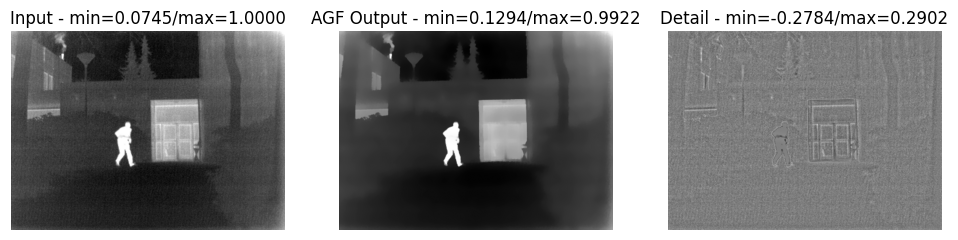

In [29]:
import numpy as np
from numba import njit, prange

@njit(parallel=True, fastmath=True)
def joint_bilateral_filter_numba(
    p,
    I,
    sigma_spatial,
    sigma_range
):
    H, W = p.shape
    radius = int(3 * sigma_spatial)
    out = np.zeros_like(p)

    # Precompute spatial kernel
    size = 2 * radius + 1
    spatial = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            dx = i - radius
            dy = j - radius
            spatial[i, j] = np.exp(-(dx*dx + dy*dy) / (2*sigma_spatial*sigma_spatial))

    for y in prange(H):
        for x in range(W):
            wsum = 0.0
            psum = 0.0
            Ic = I[y, x]

            for dy in range(-radius, radius + 1):
                yy = min(max(y + dy, 0), H - 1)
                for dx in range(-radius, radius + 1):
                    xx = min(max(x + dx, 0), W - 1)

                    gr = np.exp(
                        -((I[yy, xx] - Ic) ** 2) / (2 * sigma_range * sigma_range)
                    )
                    w = spatial[dy + radius, dx + radius] * gr

                    wsum += w
                    psum += w * p[yy, xx]

            out[y, x] = psum / (wsum + 1e-8)

    return out

import cv2

def alternating_guided_filter_fast(
    I,
    sigma_spatial=5,
    sigma_range=0.05,
    iterations=4,
    median_ksize=3
):
    I = I.astype(np.float32)
    G = np.full_like(I, np.mean(I), dtype=np.float32)

    for _ in range(iterations):
        G = joint_bilateral_filter_numba(I, G, sigma_spatial, sigma_range)
        G = joint_bilateral_filter_numba(G, I, sigma_spatial, sigma_range)

        G = cv2.medianBlur(
            (G * 255).astype(np.uint8),
            median_ksize
        ).astype(np.float32) / 255.0

    return np.clip(G, 0, 1)

img = cv2.imread("C:\\LTHH\\data\\TNO\\ir\\17.png", cv2.IMREAD_GRAYSCALE)
img = img.astype(np.float32) / 255.0

base = alternating_guided_filter_fast(
    img,
    sigma_spatial=5,
    sigma_range=0.05,
    iterations=4,
    median_ksize=3  
)

detail = img - base

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title(f"Input - min={img.min():.4f}/max={img.max():.4f}"); plt.imshow(img, cmap="gray"); plt.axis("off")
plt.subplot(1,3,2); plt.title(f"AGF Output - min={base.min():.4f}/max={base.max():.4f}"); plt.imshow(base, cmap="gray"); plt.axis("off")
plt.subplot(1,3,3); plt.title(f"Detail - min={detail.min():.4f}/max={detail.max():.4f}"); plt.imshow(detail, cmap="gray"); plt.axis("off")
plt.show()

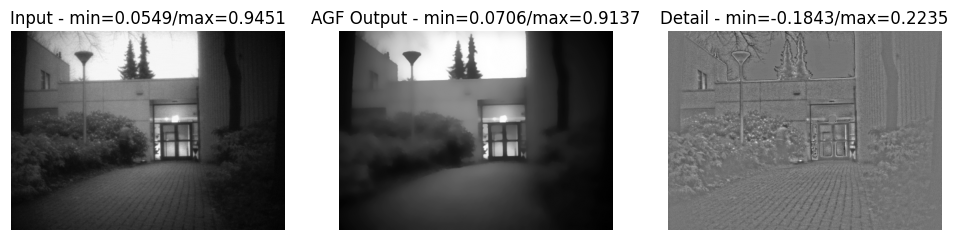

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from alternatingGuidedFilter import alternating_guided_filter_numba
from AGF_decomposition import agf_decomposition

img = cv2.imread("C:\\LTHH\\data\\TNO\\vi\\17.png", cv2.IMREAD_GRAYSCALE)
img = img.astype(np.float32) / 255.0

base, detail = agf_decomposition(
    img,
    sigma_spatial=5,
    sigma_range=0.05,
    iterations=4,
    median_ksize=3,
    numba=True
)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title(f"Input - min={img.min():.4f}/max={img.max():.4f}"); plt.imshow(img, cmap="gray"); plt.axis("off")
plt.subplot(1,3,2); plt.title(f"AGF Output - min={base.min():.4f}/max={base.max():.4f}"); plt.imshow(base, cmap="gray"); plt.axis("off")
plt.subplot(1,3,3); plt.title(f"Detail - min={detail.min():.4f}/max={detail.max():.4f}"); plt.imshow(detail, cmap="gray"); plt.axis("off")
plt.show()